In [1]:
#Se importan las librerias con las cuales se va a desarrollar el ejercicio

#Manejo de datos
import pandas as pd
import numpy as np
import os
import glob 
import openpyxl
import random
import time

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from xverse.transformer import WOE
from xverse.transformer import MonotonicBinning
from xverse.ensemble import VotingSelector
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
# import xgboost as xgb


Using TensorFlow backend.


Creación de funciones personalizadas

In [2]:
## Funciones para valores perdidos.

## Porcentaje de valores perdidos por variable
def resum_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje'])
    return missing_data

## dataFrame de resumen de posición de valores perdidos.  
def posmissing(df):
    lista_miss = np.where(df.isna())
    v1 = pd.Series(np.ndarray.tolist(lista_miss[0]))
    v2 = pd.Series(np.ndarray.tolist(lista_miss[1]))
    resumen_vna = pd.concat([v1, v2], axis=1, keys=['posicion_fila', 'posicion_columna'])
    return resumen_vna

Datos de entrenamiento / prueba

In [3]:
# Lee los nombres de archivos del directorio de trabajo
filenames = glob.glob('Datos/*.csv')

In [4]:
filenames

['Datos/DatosNegativos1.csv', 'Datos/DatosPositivos1.csv']

In [5]:
# Leemos y cargamos el contenido de los archivos .xlsx
df = pd.DataFrame()
for filename in filenames:
    data = pd.read_csv(filename)
    print(data.shape)
    df = df.append(data)

(5561, 1760)
(8322, 1761)


In [5]:
# Tamaño del set de datos completo
df.shape

(13883, 1761)

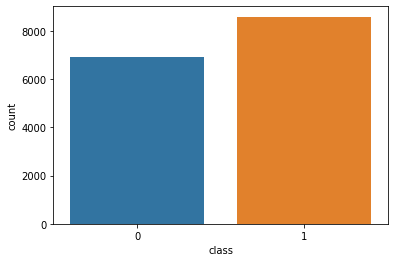

In [7]:
# Contamos los valores por clase, y vemos que la clase está desbalanceada
sns.countplot(df["class"])

Dado que la variable objetivo está desbalanceada, es necesario aplicar un método de balanceo que nos permita tener las clases equilibradas.

In [6]:
# Eliminamos la columna que ennumera del primer archivo
df_dep = df.drop(columns="Unnamed: 0")


In [90]:
df_dep.head()

,A,AA,AC,AD,AE,AF,AG,AH,AI,AK,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
0,28.571,16.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.979,0.0,1.895,0.994,0.781,0.0,0.0,0.0
1,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.769,0.0,2.119,0.028,1.000,0.0,0.0,0.0
2,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.844,0.0,0.977,0.096,0.138,0.0,0.0,0.0
3,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.564,0.0,0.504,0.096,0.095,0.0,0.0,0.0
4,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.813,0.0,0.980,0.848,0.065,0.0,0.0,0.0


In [7]:
# Creamos una columna enumerando cada fila
df_dep = df_dep.assign(num=[0 + i for i in range(len(df_dep))])[['num'] + df_dep.columns.tolist()]

In [10]:
df_dep.tail()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
1618,15501,25.000,6.67,0.0,0.00,0.0,0.0,0.00,0.0,6.67,...,0.0,0.0,3.327,0.0,4.719,3.454,3.918,3.807,1.756,2.331
1619,15502,8.333,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,5.855,0.0,6.676,6.189,6.205,4.958,4.603,5.675
1620,15503,36.000,8.33,0.0,4.17,0.0,0.0,0.00,0.0,0.00,...,0.0,0.0,7.451,0.0,5.439,4.750,6.144,5.706,5.681,3.214
1621,15504,8.000,0.00,0.0,0.00,0.0,0.0,4.17,0.0,4.17,...,0.0,0.0,5.893,0.0,5.902,5.006,3.651,4.864,4.215,4.565
1622,15505,4.167,0.00,0.0,0.00,0.0,0.0,0.00,0.0,4.35,...,0.0,0.0,11.722,0.0,7.768,9.453,10.426,8.075,9.740,5.496


In [8]:
# Guardamos las variables num y sequence
df_1 = df_dep[["num", "sequence"]]
df_1.tail()

,num,sequence
8317,13878,ILPIIGKILSTIFGK
8318,13879,YAGAVANDL
8319,13880,KKCFRWQWRMKKLGA
8320,13881,GWAGWLLSPRGSRPSWGP
8321,13882,LRRLYKRVVKLWKRLFRQLRRPVR


In [9]:
# Eliminamos la variable sequence del dataframe depurado
df_dep.pop("sequence")
df_dep.head()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
0,0,28.571,16.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.979,0.0,1.895,0.994,0.781,0.0,0.0,0.0
1,1,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.769,0.0,2.119,0.028,1.000,0.0,0.0,0.0
2,2,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.844,0.0,0.977,0.096,0.138,0.0,0.0,0.0
3,3,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.564,0.0,0.504,0.096,0.095,0.0,0.0,0.0
4,4,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.813,0.0,0.980,0.848,0.065,0.0,0.0,0.0


In [10]:
# Asignamos la variable objetivo
y = df_dep.pop("class")

Datos de validación

In [11]:
#file_= glob.glob('Datos/val/DatosValidacion1.csv')
val_data = pd.read_csv('Datos/val/DatosValidacion1.csv')
# Creamos una columna enumerando cada fila
val_data = val_data.assign(num=[1500 + i for i in range(len(val_data))])[['num'] + val_data.columns.tolist()]
val_data.pop("sequence")
val_data.pop("Unnamed: 0")
val_data.pop("Unnamed: 0.1")
y2 = val_data.pop("class")
val_data.head()

,num,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
0,1500,33,3897.77,8.691,0.002230,11.404358,-0.112121,84.766667,0.030303,85.757576,...,-0.928374,2.771416,-0.851930,-0.459909,0.909622,1.402783,-3.848056,-0.528822,-0.740751,-0.257650
1,1501,34,4003.64,7.590,0.001896,10.196106,-0.638235,76.035294,0.117647,34.411765,...,-1.030314,2.356963,-0.590644,-0.433246,0.362768,1.204798,-3.838024,-0.859893,-1.086264,0.052278
2,1502,35,4121.92,6.689,0.001623,9.611023,-0.551429,16.851429,0.057143,64.000000,...,-0.846578,2.762231,-1.182640,-0.908285,0.802487,1.546229,-4.543212,-0.786475,-0.477468,-0.178319
3,1503,31,3838.56,6.589,0.001717,9.802917,-0.200000,53.977419,0.161290,47.096774,...,-0.960986,1.742604,-0.981736,-0.098695,0.614634,0.774174,-2.818301,-0.395545,-0.738405,0.369630
4,1504,33,3715.45,3.591,0.000967,8.981384,0.660606,62.042424,0.090909,91.212121,...,-1.034936,1.734715,-0.830263,-0.386610,0.836167,0.859871,-3.665342,-0.922017,-0.364447,-0.055827


In [12]:
# Normalizamos el set de datos
names = val_data.columns
scaler = preprocessing.StandardScaler()
scaled_val_data = scaler.fit_transform(val_data)
scaled_val_data  = pd.DataFrame(scaled_val_data, columns=names)
scaled_val_data.head()

,num,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,aromaticity,aliphatic_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
0,-1.730984,1.200441,1.488957,2.993163,2.041380,1.680420,0.057637,1.795329,-0.751363,-0.178559,...,-0.709365,1.945619,-1.703364,0.675871,1.054814,3.373537,-2.357323,0.456880,-0.985170,-1.610517
1,-1.728850,1.346667,1.627166,2.600490,1.720552,1.201197,-0.688985,1.474132,0.681090,-1.690778,...,-0.996886,1.241833,-0.840013,0.748034,-0.608378,2.709067,-2.344236,-0.497817,-2.046474,-0.469698
2,-1.726715,1.492893,1.781575,2.279148,1.458301,0.969138,-0.565795,-0.703036,-0.311187,-0.819356,...,-0.478661,1.930022,-2.796106,-0.537628,0.728976,3.854966,-3.264137,-0.286104,-0.176447,-1.318507
3,-1.724581,0.907989,1.411661,2.243483,1.548356,1.045248,-0.067074,0.662700,1.396846,-1.317184,...,-0.801345,0.198585,-2.132271,1.653474,0.157642,1.263816,-1.014032,0.841203,-0.977964,0.698452
4,-1.722446,1.200441,1.250947,1.174245,0.827828,0.719407,1.154235,0.959383,0.242584,-0.017914,...,-1.009921,0.185188,-1.631771,0.874250,0.831410,1.551430,-2.118977,-0.676961,0.170717,-0.867622


## 1- Clasificación sin selección

### 1.1 Normalización

Antes de realizar el particionamiento y balanceo de los datos y aplicar los algoritmos que vamos que trabajaremos para la solución de esta necesidad, es necesario realizar un proceso de normalización, el cual nos permita tener todas las variables en la misma escala.

In [13]:
# Normalizamos el set de datos
names = df_dep.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df_dep)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [15]:
# Imprimimos los ultimos registros
scaled_df.tail()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
15501,1.731045,2.167779,2.217884,-0.148364,-0.185015,-0.197956,-0.206118,-0.300380,-0.148289,3.595427,...,-0.339796,-0.312079,-0.774868,-0.272856,-0.131701,-0.602325,-0.329742,-0.140855,-0.760411,-0.515934
15502,1.731269,0.127114,-0.305148,-0.148364,-0.185015,-0.197956,-0.206118,-0.300380,-0.148289,-0.263677,...,-0.339796,-0.312079,0.050981,-0.272856,0.527707,0.251121,0.394120,0.254773,0.220564,0.586011
15503,1.731492,3.514590,2.845805,-0.148364,3.162964,-0.197956,-0.206118,-0.300380,-0.148289,-0.263677,...,-0.339796,-0.312079,0.572364,-0.272856,0.110902,-0.197914,0.374813,0.511880,0.592004,-0.224960
15504,1.731716,0.086342,-0.305148,-0.148364,-0.185015,-0.197956,-0.206118,1.885067,-0.148289,2.148986,...,-0.339796,-0.312079,0.063395,-0.272856,0.266909,-0.118030,-0.414251,0.222463,0.086873,0.220234
15505,1.731939,-0.382960,-0.305148,-0.148364,-0.185015,-0.197956,-0.206118,-0.300380,-0.148289,2.253130,...,-0.339796,-0.312079,1.967619,-0.272856,0.895655,1.269638,1.730117,1.326165,1.990590,0.527025


### 1.2 Creación de particiones

Para el proceso de particionamiento de los datos, manejaremos el set de datos de entrenamiento con un 80% de los datos originales y utilizaremos un 20% para pruebas. Adicionalmente, vamos a utilzar un muestreo donde estratificaremos a partir de la variable objetivo para que al momento de hacer la división se mantenga la distribución de los datos

In [14]:
# Particionamos el set de datos
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size = .25, random_state=42, stratify = y)

### 1.3 Balanceamos el set de datos

Para realizar el balanceo de los datos, utilizaremos la función SMOTE, la cual es una técnica que nos permitirá hacer un sobre muestreo de la clase minoritaria, en este caso la clase representada con "0", esta función hace parte de la librería imblearn 

In [15]:
# Se balancean los datos de entrenamiento
sm = SMOTE(random_state=42)
sm_data_X, sm_data_y = sm.fit_sample(X_train, y_train)

In [16]:
## Convirtiendo en DataFrame
bal_data_X = pd.DataFrame(sm_data_X, columns=X_train.columns)
type(bal_data_X)

pandas.core.frame.DataFrame

In [17]:
bal_data_y = pd.Series(sm_data_y)
type(bal_data_y)

pandas.core.series.Series

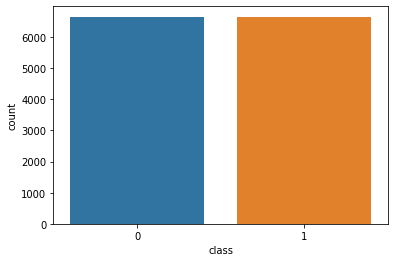

In [97]:
# Revisamos las clases
sns.countplot(bal_data_y)

Se observa que las clases ahora estan balanceadas, ahora podemos aplicar algoritmos de machine learning sin preocuparnos por la perdida de rendimiento a partir de desequilibrio de clases.

In [20]:
type(sm_data_X)

pandas.core.frame.DataFrame

In [21]:
type(sm_data_y)

pandas.core.series.Series

### Ahora, construiremos 3 clasificadores a partir de los datos preprocesados y revisaremos su rendimiento

### 1.3.1 Random Forest

In [100]:
# Entrenamos un modelo con Random Forest 
clf = RandomForestClassifier(n_estimators = 5, max_depth=5, random_state=0)
clf.fit(bal_data_X, bal_data_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [101]:
# Aplicamos validación cruzada para evaluar el performance del modelo
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(clf, bal_data_X, bal_data_y, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.02)


In [102]:
# Hacemos predicciones con la data de prueba
predict = clf.predict(X_test)

In [103]:
predict

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [104]:
# Revisamos la matriz de confusión
confusion_matrix(y_test, predict)

array([[ 983,  129],
       [ 265, 1400]], dtype=int64)

In [105]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.79      0.88      0.83      1112
           1       0.92      0.84      0.88      1665

    accuracy                           0.86      2777
   macro avg       0.85      0.86      0.85      2777
weighted avg       0.86      0.86      0.86      2777



In [ ]:
Interpretación de Resultados

Precisión: Se observa que el clasificador etiqueta de excelente forma ambas clases, sin embargo hay una oportunidad de mejorar la tasa de precisión para la clase "0".

Recall: Vemos que el clasificador tiene un buena capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento similar para ambas clases, siendo mejor para la clase "0".

F1-Score: Encontramos que el clasificador tiene un buena capacidad de predecir bien los casos positivos. Nuevamente se puede observar que lo hace mejor manera para la clase "1"

### 1.3.2 Redes Neuronales

In [106]:
# Entrenamos un modelo con Redes Neuronales
model = keras.Sequential([
    #keras.layers.Dense(len(bal_data_X.columns), activation=tf.nn.relu, input_shape=[len(bal_data_X.columns)]),
    #keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(len(bal_data_X.columns), activation=tf.nn.relu, input_shape=[len(bal_data_X.columns)]),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [107]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [108]:
model.fit(bal_data_X, bal_data_y, epochs=5)

Train on 13314 samples
Epoch 1/5
13314/13314 [==============================] - 8s 624us/sample - loss: 0.2861 - acc: 0.9090
Epoch 2/5
13314/13314 [==============================] - 8s 573us/sample - loss: 0.0793 - acc: 0.9725
Epoch 3/5
13314/13314 [==============================] - 9s 648us/sample - loss: 0.0634 - acc: 0.9787
Epoch 4/5
13314/13314 [==============================] - 8s 603us/sample - loss: 0.0621 - acc: 0.9826
Epoch 5/5
13314/13314 [==============================] - 8s 606us/sample - loss: 0.0388 - acc: 0.9890


In [109]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2777/2777 [==============================] - 1s 270us/sample - loss: 0.2001 - acc: 0.9377
Test accuracy: 0.93770254


In [110]:
# Hacemos predicciones con la data de prueba
predict = model.predict_classes(X_test)

In [112]:
#from sklearn.model_selection import KFold
 
#n_split=3
 
#for train_index,test_index in KFold(n_split).split(bal_data_X, bal_data_y):
 # x_train,x_test = bal_data_X[train_index],bal_data_X[test_index]
  #y_train1,y_test1 = bal_data_y[train_index],bal_data_y[test_index]
  
  #model=create_model()
  #model.fit(x_train, y_train1, epochs=5)
  
  #print('Model evaluation ',model.evaluate(x_test,y_test1))

In [113]:
# Revisamos la matriz de confusión
confusion_matrix(y_test, predict)

array([[1038,   74],
       [  99, 1566]], dtype=int64)

In [114]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.91      0.93      0.92      1112
           1       0.95      0.94      0.95      1665

    accuracy                           0.94      2777
   macro avg       0.93      0.94      0.94      2777
weighted avg       0.94      0.94      0.94      2777



Interpretación de Resultados

Precisión: Se observa que el clasificador etiqueta de excelente forma ambas clases, manejando mejor ajuste para la clase "1".

Recall: Vemos que el clasificador tiene una excelente capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento casi igual para ambas clases, siendo mejor para la clase "1".

F1-Score: Encontramos que el clasificador tiene una excelente capacidad de predecir bien los casos positivos. Nuevamente se puede observar que lo hace mejor manera para la clase "1"

### 1.3.4 Regresión Logística

In [18]:
#Definición del modelo de regresión logística
random.seed(1234)
lr = LogisticRegression()

In [19]:
#Determinar cuales son los hiperparametros donde se optimiza el desempeño del modelo por medio de GridSearch
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}] No se usa ya que las clases estan balanceadas
solver = ['liblinear', 'saga', 'sag', 'lbfgs', 'newton-cg']
dual = [True,False]
max_iter = [100,110,120,130,140]

param_grid = dict(penalty=penalty,
                  C=C,
                #   class_weight=class_weight,
                  solver=solver,
                  dual = dual,
                  max_iter = max_iter)

In [29]:
grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_result = grid.fit(bal_data_X, bal_data_y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 92.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 129.1min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed: 186.1min finished
Best Score:  1.0
Best Params:  {'C': 0.001, 'dual': False, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [30]:
#Con randomizedSearchCV
random = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, n_iter = 100)
random_result = random.fit(bal_data_X, bal_data_y)

print('Best Score: ', random_result.best_score_)
print('Best Params: ', random_result.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 29.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 31.8min finished
Best Score:  1.0
Best Params:  {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 110, 'dual': False, 'C': 0.001}


Modelo de regresión logística sin ajuste en los hiperparametros

In [34]:
# Entrenamos el modelo con regresión logística sin ajuste en los hiperparametros
lr.fit(bal_data_X, bal_data_y)

# Aplicamos validación cruzada para evaluar el performance del modelo
kfold = StratifiedKFold(10) #KFold(n_splits=10, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']
results_woh = cross_validate(lr, scaled_df, y, cv = kfold, scoring = scoring)
print("Accuracy: %.2f%% (+/- %.2f%%)" % (results_woh['test_accuracy'].mean()*100, results_woh['test_accuracy'].std()*100))
print("Precision: %.2f%% (+/- %.2f%%)" % (results_woh['test_precision'].mean()*100, results_woh['test_precision'].std()*100))
print("Recall: %.2f%% (+/- %.2f%%)" % (results_woh['test_recall'].mean()*100, results_woh['test_recall'].std()*100))
print("F1 score: %.2f%% (+/- %.2f%%)" % (results_woh['test_f1'].mean()*100, results_woh['test_f1'].std()*100))

Accuracy: 94.37% (+/- 5.65%)
Precision: 94.48% (+/- 8.31%)
Recall: 97.34% (+/- 4.39%)
F1 score: 95.57% (+/- 4.27%)


Text(33.0, 0.5, 'Real')

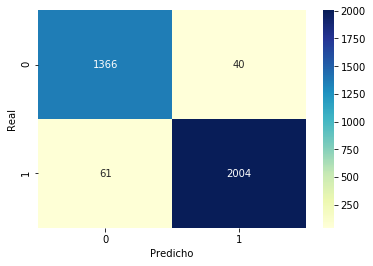

In [107]:
# Hacemos predicciones con la data de prueba
predict_log = lr.predict(X_test)

# Revisamos la matriz de confusión
rlog_cm = confusion_matrix(y_test, predict_log)
sns.heatmap(rlog_cm, fmt='', annot = True, cmap = 'YlGnBu')
plt.xlabel('Predicho')
plt.ylabel('Real')

In [108]:
print(classification_report(y_test, predict_log))

precision    recall  f1-score   support

           0       0.96      0.97      0.96      1406
           1       0.98      0.97      0.98      2065

    accuracy                           0.97      3471
   macro avg       0.97      0.97      0.97      3471
weighted avg       0.97      0.97      0.97      3471



In [32]:
predict_logval = lr.predict(scaled_val_data)
print(classification_report(y2, predict_logval))

precision    recall  f1-score   support

           0       0.55      0.23      0.32      1354
           1       0.01      0.04      0.02       269

    accuracy                           0.20      1623
   macro avg       0.28      0.14      0.17      1623
weighted avg       0.46      0.20      0.27      1623



In [33]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y2, predict_logval)

-0.334424750070623

In [111]:
results_woh = cross_validate(lr, scaled_val_data, y2, cv = StratifiedKFold(10), scoring = scoring)
print("Accuracy: %.2f%% (+/- %.2f%%)" % (results_woh['test_accuracy'].mean()*100, results_woh['test_accuracy'].std()*100))
print("Precision: %.2f%% (+/- %.2f%%)" % (results_woh['test_precision'].mean()*100, results_woh['test_precision'].std()*100))
print("F1 score: %.2f%% (+/- %.2f%%)" % (results_woh['test_f1'].mean()*100, results_woh['test_f1'].std()*100))

Accuracy: 95.87% (+/- 2.25%)
Precision: 96.29% (+/- 3.92%)
F1 score: 85.34% (+/- 9.36%)


In [173]:
%time
k_plot = []
t_plot = []
v_plot = []

for k in range(1,100,1):
    dt = LogisticRegression(C = k)
    dt.fit(bal_data_X, bal_data_y)
    predict = dt.predict(X_test)
    predict_val = dt.predict(scaled_val_data)
    predict_train = dt.predict(bal_data_X)
    recall_test = round(recall_score(y_test, predict, average=None)[1],3)
    recall_train = round(recall_score(bal_data_y, predict_train, average=None)[1],2)
    recall_val = round(recall_score(y2, predict_val, average=None)[1],2)
    #print(k)
    k_plot.append(recall_test)
    t_plot.append(recall_train)
    v_plot.append(recall_val)

CPU times: user 9 µs, sys: 5 µs, total: 14 µs
Wall time: 46.7 µs


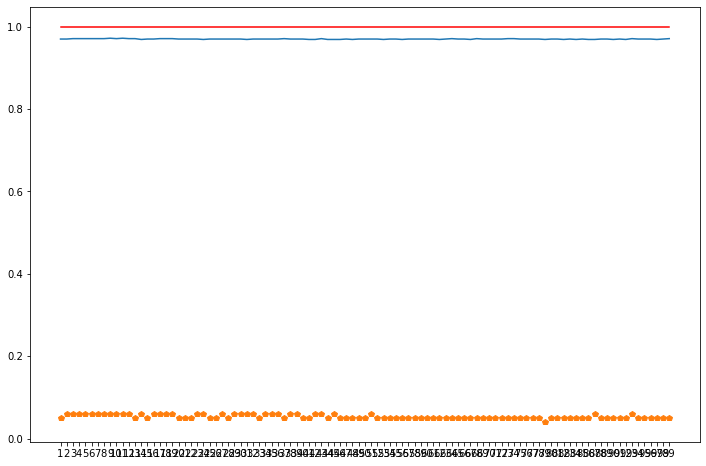

In [182]:
fig,axes = plt.subplots(1,1,figsize=(12,8))

axes.set_xticks(range(1,100,1))
k = range(1,100,1)
plt.plot(k,k_plot) ## Azul es Test
plt.plot(k,t_plot,'r') ## Rojo es entrenamiento
plt.plot(k,v_plot,'p') ## pink es entrenamiento

In [178]:
predict_val.shape

(1623,)

Modelo de regresión logística con ajuste en los hiperparametros

Accuracy: 93.79% (+/- 6.07%)
Precision: 93.93% (+/- 8.98%)
Recall: 97.34% (+/- 4.39%)
F1 score: 95.18% (+/- 4.42%)


Text(33.0, 0.5, 'Real')

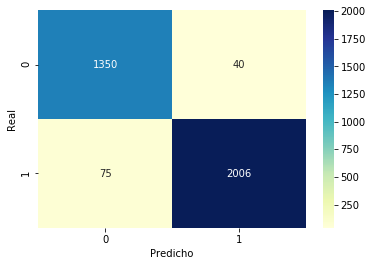

In [41]:
# Se define la regresión logística a partir de los parametros encontrados como óptimos
random.seed(1)
lr_hyp = LogisticRegression(C = 0.01)
# C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# Entrenamos el modelo con regresión logística
lr_hyp.fit(bal_data_X, bal_data_y)

# Aplicamos validación cruzada para evaluar el performance del modelo
results_why = cross_validate(lr_hyp, scaled_df, y, cv = StratifiedKFold(10), scoring = scoring)
print("Accuracy: %.2f%% (+/- %.2f%%)" % (results_why['test_accuracy'].mean()*100, results_why['test_accuracy'].std()*100))
print("Precision: %.2f%% (+/- %.2f%%)" % (results_why['test_precision'].mean()*100, results_why['test_precision'].std()*100))
print("Recall: %.2f%% (+/- %.2f%%)" % (results_woh['test_recall'].mean()*100, results_woh['test_recall'].std()*100))
print("F1 score: %.2f%% (+/- %.2f%%)" % (results_why['test_f1'].mean()*100, results_why['test_f1'].std()*100))

# Hacemos predicciones con la data de prueba
predict_log_hyp = lr_hyp.predict(X_test) 

# Revisamos la matriz de confusión
rlog_cm = confusion_matrix(y_test, predict_log_hyp) #y_test, predict_log_hyp
sns.heatmap(rlog_cm, fmt='', annot = True, cmap = 'YlGnBu')
plt.xlabel('Predicho')
plt.ylabel('Real')

In [38]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict_log_hyp))

precision    recall  f1-score   support

           0       0.85      0.93      0.89      1390
           1       0.95      0.89      0.92      2081

    accuracy                           0.91      3471
   macro avg       0.90      0.91      0.90      3471
weighted avg       0.91      0.91      0.91      3471



In [42]:
predict_logvalh = lr_hyp.predict(scaled_val_data)
print(classification_report(y2, predict_logvalh))

precision    recall  f1-score   support

           0       0.56      0.23      0.32      1354
           1       0.02      0.07      0.03       269

    accuracy                           0.20      1623
   macro avg       0.29      0.15      0.18      1623
weighted avg       0.47      0.20      0.28      1623



Interpretación de resultados

Precisión: Se observa que el clasificador etiqueta de excelente forma ambas clases, manejando mejor ajuste para la clase "1".

Recall: Vemos que el clasificador tiene una excelente capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento casi igual para ambas clases, siendo mejor para la clase "1".

F1-Score: Encontramos que el clasificador tiene una excelente capacidad de predecir bien los casos positivos. Nuevamente se puede observar que lo hace mejor manera para la clase "1"

# 2- Clasificación con Selección

## 2.1.1 Selección de Variables

In [39]:
# Revisamos valores nulos
resum_missing(df_dep).head(10)

,Total,Porcentaje
tausw9,0,0.0
MoranAuto_Mutability7,0,0.0
MoranAuto_Mutability24,0,0.0
MoranAuto_Mutability25,0,0.0
MoranAuto_Mutability26,0,0.0
MoranAuto_Mutability27,0,0.0
MoranAuto_Mutability28,0,0.0
MoranAuto_Mutability29,0,0.0
MoranAuto_Mutability3,0,0.0
MoranAuto_Mutability30,0,0.0


In [127]:
bal_data_X.describe()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
count,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,...,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000
mean,-0.178023,0.001265,-0.014507,-0.004663,0.014347,0.012347,0.016719,-0.002633,-0.005969,0.000705,...,0.010578,0.011335,0.004952,0.011040,0.019956,-0.004714,0.000432,0.027854,0.018065,0.005683
std,1.005364,0.968659,0.957377,0.972517,1.011846,0.987063,1.007835,0.984675,0.952502,0.964837,...,1.010887,1.017292,0.991851,1.005320,1.000095,0.989553,0.984848,0.992808,0.990168,0.984289
min,-1.731926,-0.863028,-0.296462,-0.148970,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,-1.833369,-0.245378,-1.698984,-1.638773,-1.529407,-1.409979,-1.321731,-1.237456
25%,-1.054157,-0.863028,-0.296462,-0.148970,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,-0.739959,-0.245378,-0.726904,-0.739137,-0.731828,-0.748304,-0.758260,-0.773703
50%,-0.344464,-0.192676,-0.296462,-0.148970,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,-0.155416,-0.245378,-0.127035,-0.175843,-0.166769,-0.123821,-0.137206,-0.178123
75%,0.691111,0.477554,-0.296462,-0.148970,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,0.613331,-0.245378,0.612360,0.592140,0.588233,0.642260,0.602339,0.616462
max,1.731926,9.995793,16.130498,17.857778,20.457451,16.877595,19.191155,13.634235,20.746522,15.401839,...,10.219024,8.902564,4.725582,10.848186,4.778758,4.777545,6.433133,4.590796,4.327463,4.710282


### RFE Random Forest

In [128]:
rf = RandomForestClassifier(n_estimators = 10, max_depth=5, random_state=42)
rf.fit(bal_data_X, bal_data_y)
mask = rf.feature_importances_ > .01
X_reduced = bal_data_X.loc[:, mask]
print(X_reduced.columns)

Index(['num', 'GearyAuto_Mutability5', 'GearyAuto_Mutability6', 'KK', 'M',
       'MoreauBrotoAuto_Mutability7', 'QSOSW12', 'QSOSW13', 'QSOSW17',
       'QSOgrant12', 'QSOgrant13', 'QSOgrant6', 'S', '_ChargeC3',
       '_ChargeD3050', '_ChargeT12', '_HydrophobicityD2001',
       '_HydrophobicityD3001', '_PolarityC3', '_PolarityD1001',
       '_PolarizabilityD3025', '_SecondaryStrD1001', '_SecondaryStrD2025',
       '_SecondaryStrD3001', '_SolventAccessibilityC1',
       '_SolventAccessibilityD1025', '_SolventAccessibilityD3001',
       '_SolventAccessibilityD3100', '_SolventAccessibilityT23',
       'isoelectric_point'],
      dtype='object')


In [129]:
rfe = RFE(estimator=RandomForestClassifier(n_estimators = 8, max_depth=8, random_state=42), n_features_to_select=400, verbose=0)
rfe.fit(bal_data_X, bal_data_y)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=8, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=8, n_jobs=None,
                                     oob_score=False, random_state=42,
                                     verbose=0, warm_start=False),
    n_features_to_select=400, step=1, verbose=0)

In [130]:
rfe_vals = bal_data_X.columns[rfe.support_]
print(rfe_vals)

Index(['num', 'A', 'AA', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI',
       ...
       'embed_0_39', 'embed_0_4', 'embed_0_40', 'embed_0_41', 'embed_0_43',
       'embed_0_44', 'embed_0_47', 'embed_0_49', 'embed_0_50', 'embed_0_51'],
      dtype='object', length=400)


## 2.1.2 Extracción de Variables

In [131]:
pca = PCA(random_state=42)
pca.fit(scaled_df)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [132]:
print(pca.explained_variance_ratio_)

[1.20047620e-01 3.04678711e-02 2.52701438e-02 ... 7.45319666e-34
 7.45319666e-34 7.45319666e-34]


In [133]:
print(pca.explained_variance_ratio_.cumsum())

[0.12004762 0.15051549 0.17578564 ... 1.         1.         1.        ]


### Miramos el número de componentes que explican la varianza

In [134]:
variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

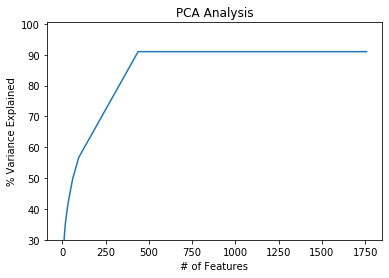

In [135]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

## 2.1.3 Peso de la Evidencia y valor de la información

In [161]:
# Seleccionamos las variables mas importantes a partir de votos generados por los modelos IV, RF, RFE, Extra trees, Chi Cuadrado, L_one. Se seleccionan a lo sumo 879 caracteristicas y para los valores perdidos se usará la media para realizar la imputación
%time
vs = VotingSelector(minimum_votes = 4)

vs.fit(bal_data_X, bal_data_y)
# vs.fit(scaled_df, y)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 23.8 µs


VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=4, no_of_features=879,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [43]:
# delta_crit = 4
# priorizadas = vs.feature_votes_[vs.feature_votes_["Votes"]>delta_crit]["Variable_Name"].values
# print("Estas son las variables más importantes, según el consenso de votos de selección,", \
#       delta_crit+1," donde las columnas de interes son:",\
#       priorizadas)

priorizadas = ['M','_SecondaryStrD2050','_PolarityD2025','embed_0_91','embed_2_75'
,'_PolarizabilityC1','MoreauBrotoAuto_Mutability4','embed_0_25'
,'GearyAuto_Hydrophobicity8','embed_1_96','_SolventAccessibilityD3050'
,'embed_2_85','embed_2_51','_PolarityD3100','GearyAuto_AvFlexibility10'
,'QSOSW11','QSOgrant11','_NormalizedVDWVD2100','embed_0_57','QSOgrant31'
,'QSOSW31','QSOgrant21','QSOSW21','_SolventAccessibilityD1050'
,'embed_1_57','_SecondaryStrD1050','embed_2_49','QSOSW19','QSOgrant19'
,'_HydrophobicityD2100','_PolarityD2001','GearyAuto_AvFlexibility14'
,'_NormalizedVDWVT12','embed_0_93','embed_1_49','GearyAuto_FreeEnergy3'
,'MoranAuto_Hydrophobicity2','GearyAuto_ResidueVol6','embed_0_50'
,'QSOSW24','QSOgrant24','embed_0_96','C','_PolarizabilityT12','embed_2_94'
,'_HydrophobicityD1001','_SolventAccessibilityD2001','embed_0_41'
,'QSOSW28','QSOgrant28','_PolarizabilityD1075','QSOSW3','QSOgrant3'
,'embed_1_90','embed_2_0','MS','embed_1_62','molecular_weight'
,'embed_2_82','GearyAuto_ResidueASA1','embed_2_90','embed_1_22','QSOSW25'
,'GearyAuto_ResidueVol23','GearyAuto_Polarizability2','embed_2_26'
,'GearyAuto_FreeEnergy16','embed_1_29','Q','_PolarizabilityD2001'
,'_ChargeD1025','MoreauBrotoAuto_Mutability6','embed_2_57'
,'GearyAuto_Steric4','GearyAuto_FreeEnergy2','embed_0_94'
,'_NormalizedVDWVD2001','GearyAuto_FreeEnergy15','embed_0_66'
,'GearyAuto_ResidueVol9','embed_1_87','N','embed_1_50'
,'MoranAuto_Hydrophobicity11','_PolarityD3025'
,'MoreauBrotoAuto_Mutability10','GearyAuto_Steric9','embed_2_91'
,'aliphatic_index','embed_2_25','embed_2_77','KC','embed_2_22'
,'embed_1_65','GearyAuto_FreeEnergy6','embed_2_24','embed_0_49'
,'embed_2_93','L','embed_1_17','tausw4','taugrant4'
,'MoreauBrotoAuto_Mutability8','embed_1_25','_NormalizedVDWVD3050'
,'embed_1_34','QSOSW30','QSOgrant30','MoranAuto_Hydrophobicity4'
,'MoranAuto_Hydrophobicity7','_PolarityD2050','_PolarityD2075'
,'GearyAuto_Mutability13','tausw7','embed_0_85'
,'GearyAuto_Hydrophobicity7','QSOgrant6','QSOSW6','GearyAuto_Mutability14'
,'FL','_ChargeD3050','R','GearyAuto_Steric22','D','_SecondaryStrD1025'
,'GearyAuto_Hydrophobicity4','_PolarityD2100','_HydrophobicityD2050'
,'embed_0_0','MoreauBrotoAuto_Mutability12','_HydrophobicityT12'
,'GearyAuto_Mutability22','_ChargeD3100','GearyAuto_FreeEnergy8'
,'_SolventAccessibilityT13','GearyAuto_AvFlexibility11'
,'GearyAuto_Hydrophobicity11','taugrant7','_PolarizabilityD3025'
,'_NormalizedVDWVD3025','QSOgrant13','QSOSW13','_SolventAccessibilityC3'
,'charge_density','_SecondaryStrD1001','_SolventAccessibilityD3001'
,'_SolventAccessibilityD1001','_HydrophobicityD3001','_ChargeC1'
,'_PolarityD1001','_NormalizedVDWVD3001','_PolarizabilityD3001'
,'_PolarityC3','GearyAuto_Steric6','embed_0_22','embed_0_68'
,'_PolarizabilityD1050','embed_0_34','tausw10','_PolarityT13'
,'_SecondaryStrD3001','_SecondaryStrD2001','_SolventAccessibilityC1'
,'taugrant10','_ChargeC3','GearyAuto_AvFlexibility2'
,'GearyAuto_ResidueVol10','_PolarityD3001','KL','embed_2_79','ML','W'
,'GearyAuto_ResidueVol14','QSOSW27','QSOgrant27','embed_0_75'
,'_SolventAccessibilityD1025','GearyAuto_Steric5','_ChargeD3025'
,'embed_0_53','GearyAuto_Hydrophobicity1','MT','embed_2_47','embed_1_79'
,'_PolarityT12','embed_1_24','embed_0_51','GearyAuto_FreeEnergy23'
,'GearyAuto_FreeEnergy17','taugrant8','tausw8','GearyAuto_Mutability10'
,'MoreauBrotoAuto_Mutability1','embed_0_37','GearyAuto_AvFlexibility7'
,'_PolarityD1025','_SolventAccessibilityD3100'
,'MoreauBrotoAuto_Mutability7','_SecondaryStrD3100','_ChargeD2001'
,'embed_1_66','_HydrophobicityC3','embed_2_44','embed_1_40','embed_2_29'
,'embed_1_77','MoranAuto_FreeEnergy8','GearyAuto_ResidueASA9','embed_1_47'
,'GearyAuto_ResidueVol2','MoranAuto_Hydrophobicity9','embed_2_84'
,'GearyAuto_ResidueVol5','GearyAuto_Hydrophobicity16'
,'_PolarizabilityD2025','embed_2_40','_NormalizedVDWVD3075'
,'_PolarityD3050','embed_0_23','GearyAuto_AvFlexibility9','_ChargeD2075'
,'_SolventAccessibilityD3075','_NormalizedVDWVD2025'
,'_NormalizedVDWVD1050','_ChargeD1001','MoreauBrotoAuto_AvFlexibility12'
,'GearyAuto_AvFlexibility3','GearyAuto_ResidueVol24','embed_2_21'
,'QSOgrant9','MoreauBrotoAuto_ResidueVol3','_HydrophobicityT23'
,'GearyAuto_Steric3','tausw12','GearyAuto_AvFlexibility17','embed_1_53'
,'embed_0_29','embed_1_23','_NormalizedVDWVT13','embed_2_28','embed_1_21'
,'taugrant11','embed_0_1','GearyAuto_FreeEnergy19','embed_0_47'
,'GearyAuto_ResidueVol8','_PolarizabilityD3075','embed_2_87'
,'_NormalizedVDWVD2050','LA','QSOgrant29','_PolarityD3075'
,'GearyAuto_ResidueASA6','embed_2_73','taugrant9','tausw9'
,'MoranAuto_ResidueVol10','_NormalizedVDWVD2075','embed_1_20'
,'MoreauBrotoAuto_FreeEnergy19','AD','GearyAuto_Hydrophobicity5'
,'embed_0_44','MoranAuto_ResidueVol2','embed_2_97','GearyAuto_ResidueASA3'
,'GearyAuto_Polarizability10','embed_1_60','MoreauBrotoAuto_ResidueVol10'
,'embed_1_97','GearyAuto_Hydrophobicity2','GearyAuto_Hydrophobicity6'
,'_PolarizabilityD2050','MoreauBrotoAuto_AvFlexibility10'
,'MoreauBrotoAuto_Polarizability11','_HydrophobicityC1','G'
,'GearyAuto_ResidueASA4','GearyAuto_Polarizability11'
,'GearyAuto_AvFlexibility1','GearyAuto_Steric17','embed_0_58','embed_0_64'
,'MoreauBrotoAuto_Hydrophobicity7','MoranAuto_Steric1'
,'_SecondaryStrD1075','embed_1_42','P','GearyAuto_ResidueASA5'
,'embed_2_67','embed_1_15','MoranAuto_FreeEnergy1','NF'
,'GearyAuto_Polarizability6','MoranAuto_Steric4','GearyAuto_FreeEnergy20'
,'_SolventAccessibilityD1075','_SolventAccessibilityD2025'
,'_HydrophobicityD1025','embed_0_97','MoranAuto_Hydrophobicity1'
,'embed_2_88','MoranAuto_Hydrophobicity10','_SolventAccessibilityC2'
,'GearyAuto_ResidueASA2','embed_1_28','embed_2_20','_SecondaryStrD2100'
,'embed_1_71','GearyAuto_Hydrophobicity9','GearyAuto_Mutability21'
,'_SecondaryStrT12','GearyAuto_ResidueASA10','embed_1_19','embed_1_41'
,'embed_0_27','MoreauBrotoAuto_Hydrophobicity10','embed_2_8'
,'MoranAuto_AvFlexibility10','MoreauBrotoAuto_Steric22'
,'GearyAuto_Polarizability1','_PolarityT23','embed_2_42'
,'GearyAuto_ResidueVol3','embed_1_91','embed_2_34','embed_1_36'
,'embed_0_26','GearyAuto_AvFlexibility19','embed_2_38'
,'GearyAuto_Hydrophobicity19','embed_2_27','MoreauBrotoAuto_Steric11','MG'
,'embed_2_99','QSOgrant5','QSOSW5','MoreauBrotoAuto_FreeEnergy10'
,'embed_1_18','GearyAuto_FreeEnergy26','MoranAuto_FreeEnergy6'
,'MoranAuto_Steric11','MoreauBrotoAuto_Hydrophobicity11'
,'_NormalizedVDWVC2','embed_1_73','embed_0_24','embed_0_77','embed_2_65'
,'MoreauBrotoAuto_Mutability9','embed_1_64','WW'
,'MoreauBrotoAuto_Hydrophobicity8','QSOSW29','embed_1_32','embed_2_41'
,'embed_0_40','GearyAuto_Steric2','num','_NormalizedVDWVC3'
,'GearyAuto_Mutability1','H','GearyAuto_ResidueVol1'
,'GearyAuto_Mutability11','GearyAuto_AvFlexibility18','GearyAuto_Steric14'
,'embed_1_59','MoranAuto_Mutability3','CK'
,'MoreauBrotoAuto_Hydrophobicity14','embed_2_23','embed_1_84','embed_1_0'
,'GearyAuto_Mutability9','_PolarizabilityC3','MV','GearyAuto_FreeEnergy1'
,'embed_0_62','MR','GearyAuto_Mutability4','_SecondaryStrD3050'
,'embed_2_59','QSOgrant18','_SolventAccessibilityT12','embed_1_4'
,'GearyAuto_Mutability6','E','embed_2_4','RR','_ChargeD1100'
,'_ChargeD3001','_HydrophobicityC2','tausw13','_SecondaryStrC1'
,'_SolventAccessibilityD3025','S','MoranAuto_Mutability5'
,'GearyAuto_Mutability7','_SecondaryStrT23','GearyAuto_Mutability12'
,'GearyAuto_Hydrophobicity3','QSOSW18','QSOSW34','_SecondaryStrC3'
,'QSOgrant34','embed_1_51','_SecondaryStrD3075','QSOgrant22','MN'
,'GearyAuto_AvFlexibility13','QSOSW22','_PolarizabilityD3050'
,'MoranAuto_FreeEnergy9','MoreauBrotoAuto_Mutability3'
,'MoranAuto_AvFlexibility7','GK','T','QSOgrant17','Y','embed_2_62'
,'QSOSW17','GearyAuto_AvFlexibility12','GearyAuto_FreeEnergy12','MK'
,'_ChargeC2','MoreauBrotoAuto_Mutability2','embed_0_17'
,'_SecondaryStrD2025','GearyAuto_FreeEnergy4','GearyAuto_Steric10'
,'_ChargeT13','LL','QSOgrant25','_SecondaryStrD3025'
,'GearyAuto_FreeEnergy5','GearyAuto_Mutability8','LK'
,'MoranAuto_Mutability2','GearyAuto_ResidueVol12','QSOSW16'
,'GearyAuto_Steric13','QSOgrant16','GearyAuto_FreeEnergy7','embed_0_84'
,'MoreauBrotoAuto_Hydrophobicity13','GearyAuto_FreeEnergy10'
,'_HydrophobicityD3025','MoranAuto_AvFlexibility2','KI','embed_0_90'
,'_SecondaryStrT13','embed_0_7','GearyAuto_FreeEnergy14'
,'GearyAuto_Steric8','GearyAuto_Hydrophobicity13','MoranAuto_Mutability1'
,'QSOSW12','QSOgrant12','embed_2_96','_PolarizabilityD1001','length'
,'embed_2_17','_NormalizedVDWVC1','KA','GearyAuto_ResidueVol21'
,'MoranAuto_Mutability14','KK','_HydrophobicityD2025','QSOSW7'
,'isoelectric_point','K','_ChargeT12','GearyAuto_Hydrophobicity10'
,'embed_1_26','GearyAuto_FreeEnergy18','GearyAuto_Steric1','embed_1_46'
,'QSOgrant7','GearyAuto_AvFlexibility16','embed_2_66'
,'GearyAuto_ResidueASA12','_SolventAccessibilityT23'
,'MoranAuto_Mutability6','WK','GearyAuto_AvFlexibility4'
,'_PolarizabilityD1100','charge','QSOSW33','LT','QSOgrant33'
,'GearyAuto_FreeEnergy22','QSOgrant4','GearyAuto_FreeEnergy21','QSOSW4'
,'_ChargeD3075','GearyAuto_Polarizability12','embed_0_87'
,'GearyAuto_Hydrophobicity12','GearyAuto_Mutability3'
,'GearyAuto_Mutability2','GearyAuto_Steric12','_HydrophobicityT13'
,'_ChargeD1075','_HydrophobicityD2001','GearyAuto_Hydrophobicity15'
,'MoranAuto_AvFlexibility12','_PolarityC2','_NormalizedVDWVD1001'
,'_ChargeT23','MoreauBrotoAuto_Mutability5','_NormalizedVDWVD1075'
,'GearyAuto_AvFlexibility8','GearyAuto_Mutability5','_PolarizabilityT23'
,'MI','_HydrophobicityD2075']

De 1758 caracterististicas se seleccionaros 746 como las más importantes 

## 2.2 Entrenar con las caracteristicas seleccionadas

In [44]:
data_val_x = scaled_val_data[priorizadas] #vs.transform(scaled_df)
data_val_y = y2

## 2.2.1 Random Forest (Validación)

In [215]:
# Entrenamos un modelo con Random Forest 
rf = RandomForestClassifier(n_estimators = 5, max_depth=5, random_state=42)
rf.fit(bal_data_X[priorizadas], bal_data_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [216]:
# Hacemos predicciones con la data de prueba
predict = rf.predict(X_test[priorizadas])

In [217]:
# Revisamos la matriz de confusión
confusion_matrix(y_test, predict)

array([[1000,  112],
       [ 137, 1528]], dtype=int64)

In [218]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.88      0.90      0.89      1112
           1       0.93      0.92      0.92      1665

    accuracy                           0.91      2777
   macro avg       0.91      0.91      0.91      2777
weighted avg       0.91      0.91      0.91      2777



## 2.2.2 Redes Neuronales (Validación)

In [219]:
n_net = keras.Sequential([
    #keras.layers.Dense(len(bal_data_X.columns), activation=tf.nn.relu, input_shape=[len(bal_data_X.columns)]),
    #keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(len(bal_data_X[priorizadas].columns), activation=tf.nn.relu, input_shape=[len(bal_data_X[priorizadas].columns)]),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [220]:
n_net.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [221]:
n_net.fit(bal_data_X[priorizadas], bal_data_y, epochs=5)

Train on 13314 samples
Epoch 1/5
13314/13314 [==============================] - 4s 293us/sample - loss: 0.1842 - acc: 0.9277
Epoch 2/5
13314/13314 [==============================] - 5s 353us/sample - loss: 0.0650 - acc: 0.9753
Epoch 3/5
13314/13314 [==============================] - 4s 327us/sample - loss: 0.0380 - acc: 0.9880
Epoch 4/5
13314/13314 [==============================] - 7s 508us/sample - loss: 0.0367 - acc: 0.9881
Epoch 5/5
13314/13314 [==============================] - 4s 321us/sample - loss: 0.0274 - acc: 0.9913


In [222]:
predict = n_net.predict_classes(X_test[priorizadas])

In [223]:
# Revisamos la matriz de confusión
confusion_matrix(y_test, predict)

array([[1077,   35],
       [  52, 1613]], dtype=int64)

In [224]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.95      0.97      0.96      1112
           1       0.98      0.97      0.97      1665

    accuracy                           0.97      2777
   macro avg       0.97      0.97      0.97      2777
weighted avg       0.97      0.97      0.97      2777



## 2.2.3 Regresión Logística (Validación)

In [45]:
random.seed(12)
lr_sc = LogisticRegression()

Se revisan si los hiperparametros hallados anteriormente para la regresión logística cambian por el cambio en el número de caracteristicas 

In [121]:
#Con randomizedSearchCV
random_sc = RandomizedSearchCV(estimator=lr_sc, param_distributions=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, n_iter = 100)
random_result_sc = random_sc.fit(bal_data_X[priorizadas], bal_data_y)

print('Best Score: ', random_result_sc.best_score_)
print('Best Params: ', random_result_sc.best_params_)

NameError: name 'priorizadas' is not defined

Realmente no hay ajustes relevantes en los hiperparametros

In [87]:
lr_sc = LogisticRegression(C = 0.0001, solver= 'saga', penalty= 'l2', max_iter= 5)
lr_sc.fit(bal_data_X[priorizadas], bal_data_y)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
# Aplicamos validación cruzada para evaluar el performance del modelo
results_lrsc = cross_validate(lr_sc, scaled_df[priorizadas], y, cv = StratifiedKFold(10), scoring = scoring)
print("Accuracy: %.2f%% (+/- %.2f%%)" % (results_lrsc['test_accuracy'].mean()*100, results_lrsc['test_accuracy'].std()*100))
print("Precision: %.2f%% (+/- %.2f%%)" % (results_lrsc['test_precision'].mean()*100, results_lrsc['test_precision'].std()*100))
print("Precision: %.2f%% (+/- %.2f%%)" % (results_lrsc['test_recall'].mean()*100, results_lrsc['test_recall'].std()*100))
print("F1 score: %.2f%% (+/- %.2f%%)" % (results_lrsc['test_f1'].mean()*100, results_lrsc['test_f1'].std()*100))

Accuracy: 86.51% (+/- 7.36%)
Precision: 88.00% (+/- 9.57%)
Precision: 91.69% (+/- 2.64%)
F1 score: 89.40% (+/- 4.69%)


Text(33.0, 0.5, 'Real')

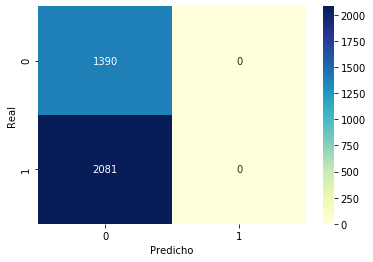

In [54]:
# Hacemos predicciones con la data de valición
predict_lrsc = lr_sc.predict(X_test[priorizadas])

# Revisamos la matriz de confusión
rlogsc_cm = confusion_matrix(y_test, predict_lrsc)
sns.heatmap(rlogsc_cm, fmt='', annot = True, cmap = 'YlGnBu')
plt.xlabel('Predicho')
plt.ylabel('Real')

In [89]:
# Revisamos otras metricas del modelo
predict_valrsc = lr_sc.predict(scaled_val_data[priorizadas])
print(classification_report(y2, predict_valrsc))

precision    recall  f1-score   support

           0       0.98      0.50      0.66      1354
           1       0.27      0.94      0.42       269

    accuracy                           0.57      1623
   macro avg       0.62      0.72      0.54      1623
weighted avg       0.86      0.57      0.62      1623

